## imports

In [11]:
import sys
import os
import h5py

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Running on Computer: [beast]
Save_dir = ./Monocular/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading expt04
  Time embedding...
11 cells, 362504 time steps.


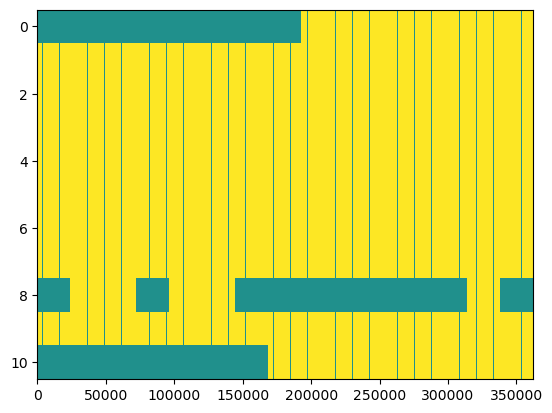

In [48]:
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

## STA

(36, 10, 11)


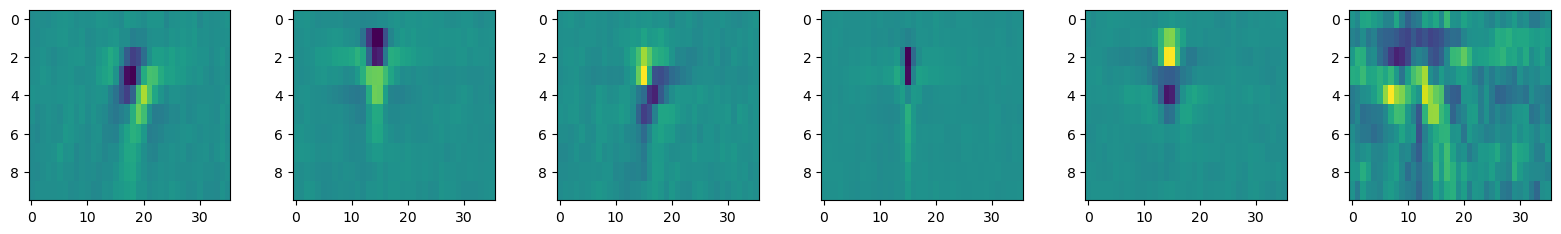

In [37]:
# Calculate STA 
Reff = data.robs * data.dfs
nspks = torch.sum(Reff, axis=0)
stas = (data.stim.T@data.robs / nspks).reshape([-1, num_lags, data.NC]).detach().numpy()
print(stas.shape)
# plot first 6
num_col = np.minimum(stas.shape[-1], 6)
ss(1, num_col)
for cc in range(num_col):
    plt.subplot(1, num_col, cc+1)
    imagesc(stas[:, :, cc])

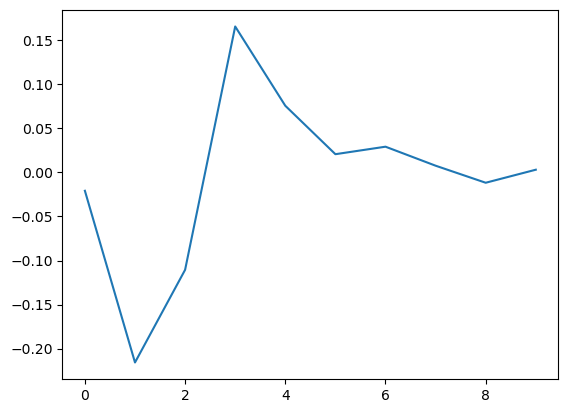

In [14]:
plt.plot(stas[13,:,1])
plt.show()

## GLMs

In [38]:
lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    history_size=10,
    batch_size=4000,
    max_epochs=25,
    max_iter = 2000,
    device = device)

In [39]:
XTreg0 = 1.0
L1reg0 = 0.0001

glm_all_par = NDNLayer.layer_dict(
    input_dims=data.stim_dims, num_filters=data.NC,
    bias=True, initialize_center = True,
    NLtype='softplus')
glm_all_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'localx':0.001, 'bcs':{'d2xt':1}  } 

In [40]:
## Fit all GLMs at once -- example for choice of regularization above
glm_all = NDN.NDN( layer_list=[glm_all_par] )
glm_all.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)
LLs = glm_all.eval_models(data[data.val_inds], null_adjusted=True)
print(LLs, np.mean(LLs))

[0.5066931  0.52749455 0.9933288  0.27660477 0.4424169  0.02551532
 0.15508842 0.2313888  0.09809875 0.06253862 0.40114594] 0.33821037


In [41]:
## Optimize d2xt regularization
# compare losses for different regularization parameters
reglist = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
LLsR = np.zeros([len(reglist), data.NC])
data.set_cells()
for rr in range(len(reglist)):
    glm_all_par['reg_vals']['d2xt'] = reglist[rr]
    glm_iter = NDN.NDN( layer_list=[glm_all_par] )
    # fit the GLM with the current regularization parameter
    glm_iter.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)
    LLsR[rr, :] = glm_iter.eval_models(data[data.val_inds], null_adjusted=True)
    print( "%7.2f  %9.7f  %9.7f"%(reglist[rr], np.mean(LLsR[rr,:]), LLsR[rr, 1]) )

  Reset cells_out to full dataset (11 cells).
   0.00  0.3575586  0.5388737
   0.00  0.3576533  0.5388683
   0.01  0.3581394  0.5388831
   0.03  0.3591619  0.5388954
   0.10  0.3603139  0.5387840
   0.30  0.3572526  0.5374849
   1.00  0.3382034  0.5274909
   3.00  0.2967034  0.4924617
  10.00  0.2284059  0.4092914
  30.00  0.1596973  0.3030728
 100.00  0.0918378  0.1798733
 300.00  0.0476211  0.0905716


In [50]:
LLsR.shape, len(reglist)

((12, 11), 12)

In [42]:
# get the maximum loss averaged over the regularization values 
LLs0 = np.max(np.mean(LLsR, axis=1))
LLs0

0.36031389236450195

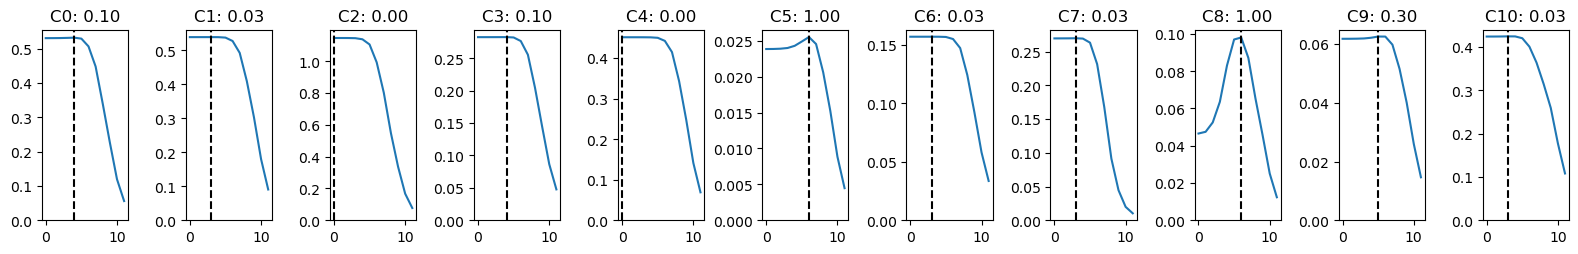

In [46]:
XTregs0 = np.zeros(data.NC)

num_col = np.minimum(data.NC, 11)
ss(1, num_col)
for cc in range(data.NC):
    b = np.argmax(LLsR[:, cc])
    XTregs0[cc] = reglist[b]

    # loss per cell
    if cc < num_col:
        plt.subplot(1, num_col, cc+1)
        plt.plot(LLsR[:, cc])
        ys = plt.ylim()
        plt.plot([b, b], [0, ys[1]], 'k--')
        plt.ylim([0, ys[1]])
        plt.title("C%d: %0.2f"%(cc, XTregs0[cc]))
plt.show()

## plot the GLM filters

## Nonlinear modeling -- jump right to shared models

In [21]:
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1)
adam_pars['device'] = device

In [22]:
## Shared NIM
num_subs = 12
XTreg0 = 0.1
L1reg0 = 0.0001
Greg = 0.001

# subunit layer
sub_par = NDNLayer.layer_dict(
    input_dims=data.stim_dims, num_filters=num_subs, norm_type=1,
    NLtype='relu', bias=False, initialize_center = True)
sub_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'localx':0.001, 'bcs':{'d2xt':1}  }

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC, norm_type=0,
    NLtype='softplus', bias=True, initialize_center = True)

nim_all = NDN.NDN( layer_list=[sub_par, readout_par] )
nim_all.fit(data, **adam_pars, verbose=2)
LLs1 = nim_all.eval_models(data[data.val_inds], null_adjusted=True)
print(LLs0, np.mean(LLs1))

Model: M011_NN

GPU Available: True, GPU Used: True


Validating ver=1: 100%|█████████████████████| 35/35 [00:01<00:00, 20.78it/s, val_loss=4.5]


Early stopping
Done fitting
  Fit complete: 201.94249820709229 sec elapsed
0.360304442319003 0.38862646


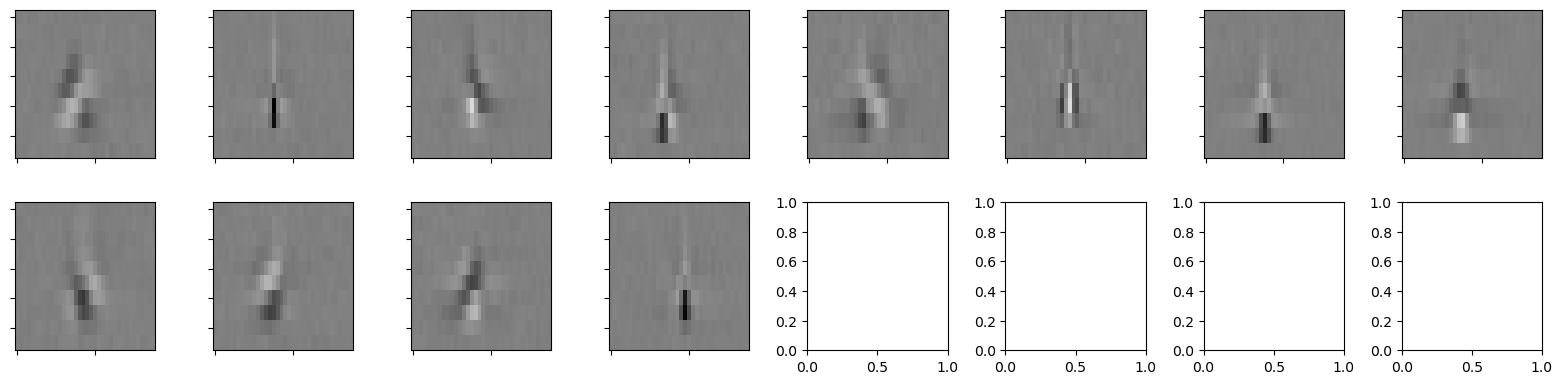

In [23]:
nim_all.plot_filters()

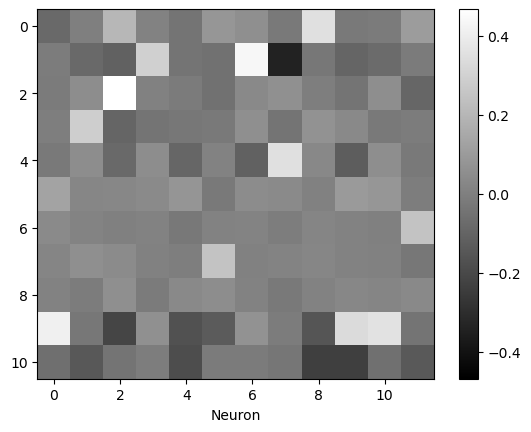

In [24]:
# Readout layer
wR = nim_all.get_weights(layer_target=1)
imagesc(wR, cmap='gray')
plt.xlabel('Subunit')
plt.xlabel('Neuron')
plt.colorbar()
plt.show()

In [25]:
## If there is enough memory on the device, can put the whole dataloader on the GPU
#del train_ds , val_ds
torch.cuda.empty_cache()

data.set_cells()
train_ds = GenericDataset(data[data.train_inds], device=device)
val_ds = GenericDataset(data[data.val_inds], device=device)

  Reset cells_out to full dataset (11 cells).


In [28]:
## About 2x speedup
nim_all = NDN.NDN( layer_list=[sub_par, readout_par])
nim_all.fit_dl(train_ds, val_ds, **adam_pars, verbose=2)
LLs1 = nim_all.eval_models(val_ds, null_adjusted=True)
print(LLs0, np.mean(LLs1))


GPU Available: True, GPU Used: True


Validating ver=2: 100%|███████████████████| 35/35 [00:00<00:00, 66.48it/s, val_loss=0.431]


Early stopping
Done fitting
  Fit complete: 75.61491751670837 sec elapsed


Eval models: 100%|███████████████████████████████████████| 69/69 [00:00<00:00, 119.92it/s]

0.360304442319003 0.2776666


In [29]:
## Shared convolutional NIM
num_subs = 8
fw = 21
XTreg0 = 0.01
L1reg0 = 0.0001
Greg = 0.001
# subunit layer
csub_par = ConvLayer.layer_dict(
    input_dims=data.stim_dims, num_filters=num_subs, norm_type=1,
    num_inh=num_subs//2, filter_dims=fw, window='hamming',
    NLtype='relu', bias=False, initialize_center = True)
csub_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'center':Creg, 'bcs':{'d2xt':1}  }

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC, norm_type=0,
    NLtype='softplus', bias=True,
    pos_constraint=True,
    initialize_center = True)
readout_par['reg_vals'] = {'glocalx': Greg  }
cnim_all = NDN.NDN( layer_list=[csub_par, readout_par] )
cnim_all.list_parameters()

NameError: name 'Creg' is not defined

In [30]:
cnim_all.fit_dl(train_ds, val_ds, **adam_pars, verbose=2)
LLs1 = cnim_all.eval_models(val_ds, null_adjusted=True)
print(LLs0, np.mean(LLs1))

NameError: name 'cnim_all' is not defined

In [31]:
cnim_all.plot_filters()

NameError: name 'cnim_all' is not defined

In [32]:
# Readout layer
wR = cnim_all.get_weights(layer_target=1)
wR.shape
# Make inhibitory weights less than zero
wR[num_subs//2:, :] *= -1
num_col = np.minimum(data.NC, 6)
ss(2, num_col//2)
for cc in range(num_col):
    plt.subplot(2, num_col//2, cc+1)
    imagesc(wR[:,:,cc].T, cmap='bwr')
    plt.ylabel('Subunit')
    plt.xlabel('Space')
    plt.colorbar()
plt.show()

NameError: name 'cnim_all' is not defined

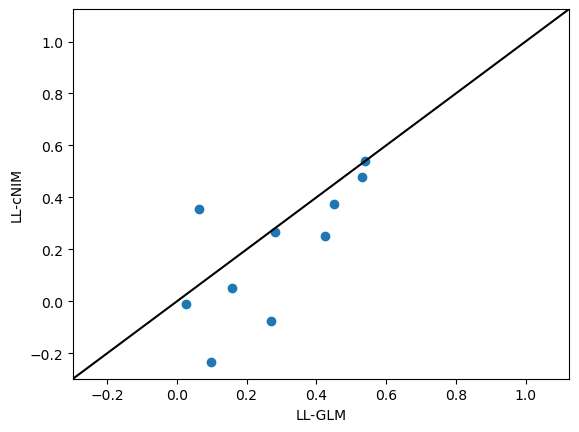

In [33]:
LLsGLM = np.max(LLsR, axis=0)
plt.plot(LLsGLM, LLs1,'o')
ys = plt.ylim()
plt.plot(ys, ys, 'k')
plt.xlim(ys)
plt.ylim(ys)
plt.xlabel("LL-GLM")
plt.ylabel("LL-cNIM")
plt.show()

## Deeper models - 3-layer scaffold

In [34]:
num_subs = [8, 8, 4]
fws = [21, 5, 5]  
XTreg = 0.1
Greg = 0.001
Creg= 1.0

clayers = []
for ii in range(0,len(num_subs)):
    clayers.append(
        ConvLayer.layer_dict( 
            num_filters=num_subs[ii], bias=False, norm_type=1,
            filter_dims=fws[ii], padding='same', NLtype='relu', initialize_center = True) )
    #clayers[ii]['output_norm'] = 'batch'
clayers[0]['input_dims'] = data.stim_dims
clayers[0]['window'] = 'hamming'
clayers[0]['reg_vals'] = {'d2xt': XTreg, 'center': Creg, 'bcs':{'d2xt':1} } 

scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold',
    xstim_n = 'stim', layer_list = clayers )

# 'readout' layer
readout_par = NDNLayer.layer_dict( 
    num_filters=data.NC, norm_type=0,
    NLtype='softplus', bias=True, 
    pos_constraint=True,
    initialize_center = True)
readout_par['reg_vals'] = {'glocalx': Greg  } 

readout_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_par], ffnet_type='normal')

cnn0 = NDN.NDN( ffnet_list=[scaffold_net, readout_net] )
cnn0.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([40, 8])
  Layer 2:
      weight: torch.Size([40, 4])
Network 1:
  Layer 0:
      weight: torch.Size([720, 11])
      bias: torch.Size([11])


In [35]:
cnn0.fit_dl(train_ds, val_ds, **adam_pars, verbose=2)
LLs1 = cnn0.eval_models(val_ds, null_adjusted=True)
print(LLs0, np.mean(LLs1))


GPU Available: True, GPU Used: True


Validating ver=1: 100%|███████████████████| 35/35 [00:00<00:00, 65.69it/s, val_loss=0.513]


Early stopping
Done fitting
  Fit complete: 42.619227170944214 sec elapsed


Eval models: 100%|████████████████████████████████████████| 69/69 [00:00<00:00, 96.80it/s]

0.360304442319003 -0.004095717


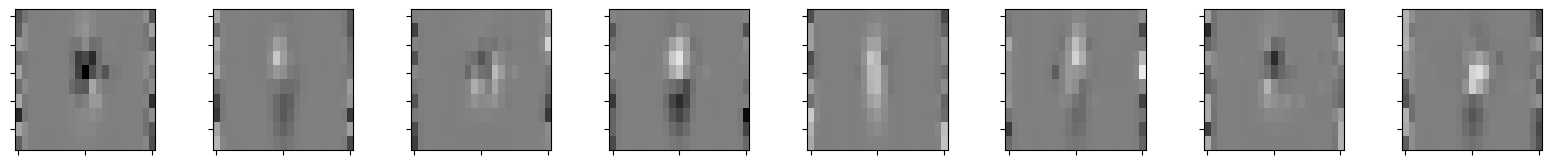

In [36]:
cnn0.plot_filters()

Can't seem to get rid of weird edge artifacts. Very likely the number of parameters is not adequately supported by the data.

## can we fit multiple datasets simultaneously using the DataFilters? Does the NDNT support this, or do I need to add this feature?